# MCCE-generated water distribution in Gramicidin channel
In the following, we take a look at data generated from MCCE.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
fontsize=10
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : fontsize}

plt.rc('font', **font)
import sys
import numpy as np
import mdtraj as md
import parmed as pm
from collections import OrderedDict
from __future__ import division
from sstmap.grid_water_analysis import *
from sstmap.utils import write_watpdb_from_coords


/Users/kamranhaider/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Obtain occupacy data

In [2]:
def read_head3lst(head3lst_file):
    residues = OrderedDict()
    with open(head3lst_file, 'r') as f:
        lines = [l.strip().split() for l in f.readlines()]
        header = lines.pop(0)
        data = [l[2:-1] for l in lines]
        conf_names = [l[1] for l in lines]
        for index, d in enumerate(data):
            if d[0] == "f":
                d[0] = 0
            else:
                d[0] = 1
            data[index] = [float(i) for i in d]
        for index, n in enumerate(conf_names):
            #print n, n[0:3] + n[5:10]
            k = n[0:3] + n[5:10]
            if k not in residues.keys():
                residues[k] = [index]
            else:
                residues[k].append(index)
        
    return header, conf_names, residues, np.asarray(data)

def read_fort38(fort38_file):
    with open(fort38_file, 'r') as f:
        lines = [l.strip().split() for l in f.readlines()]
        header = lines.pop(0)
        data = OrderedDict()
        for l in lines:
            line = [float(i) for i in l[1:]]
            data[l[0]] = line
        return data

def write_watpdb_from_coords(filename, coords, start_name):
    """Writes out PDB file from the a coordinate array. Only specific to writing
    out water molecules."
    
    Parameters
    ----------
    filename : string, required
        Name of the PDB file to write
    coords : numpy.ndarray
        An N x 3 array where N is the number of atoms
    full_water_res : bool, optional
        If True, it is assumed that the array of coordinates correspond to
        a set of full water residues (including O, H1 and H2). By default,
        it is assumed that all coordinates coorespond to water oxygens.
    """

    pdb_line_format = "{0:6}{1:>5}{2:>3}{3:<3}{4:>3} {5:1}{6:>04}{7:1}{8[0]:>8.3f}{8[1]:>8.3f}{8[2]:>8.3f}{9:>8.3f}{10:>12.3f}{11:>16s}\n"
    ter_line_format = "{0:3}   {1:>5}      {2:>3} {3:1}{4:4} \n"
    pdb_lines = []
    at = start_name
    wat_i = 0
    with open(filename + ".pdb", 'w') as f:
        #f.write("REMARK Initial number of clusters: N/A\n")
        while wat_i < len(coords):
            res = coords[wat_i][2]
            at_index = at  # % 10000
            res_index = res % 10000
            wat_coords = coords[wat_i][0]
            conf_id = "_%03d" % coords[wat_i][1]
            chain_id = "A"
            pdb_line = pdb_line_format.format(
                "ATOM", at_index, "O", " ", "HOH", chain_id, res_index, conf_id, wat_coords, 1.600, -0.834, "01O000H011")
            f.write(pdb_line)
            wat_i += 1
            H1_coords = coords[wat_i][0]
            pdb_line_H1 = pdb_line_format.format("ATOM", at_index + 1, "1H", " ", "HOH", chain_id, res_index, conf_id,
                                                 H1_coords,  1.000, 0.417, "01O000H011")
            f.write(pdb_line_H1)
            H2_coords = coords[wat_i + 1][0]
            pdb_line_H2 = pdb_line_format.format("ATOM", at_index + 2, "2H", " ", "HOH", chain_id, res_index, conf_id,
                                                 H2_coords, 1.000, 0.417, "01O000H011")
            f.write(pdb_line_H2)
            at += 3
            res += 1
            wat_i += 2
            if res_index == 9999:
                ter_line = ter_line_format.format("TER", at, "HOH", chain_id, res_index)
                at = 1

Use occupancy data to write out a new pdb fie for high occupancy waters.

('Processing data for conf_number = ', 1)
('Processing data for conf_number = ', 5)
('Processing data for conf_number = ', 10)
('Processing data for conf_number = ', 25)


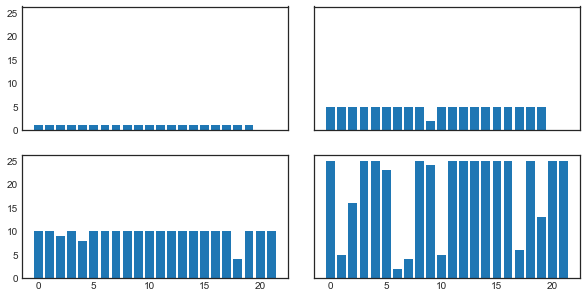

In [16]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 5))
#fig, ax = plt.subplots(2, 2, figsize=(10, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
sub_plot_indices = [(i, j) for i in range(2) for j in range(2)]
data = [(1, 1), (2, 5),(3, 10),(4, 25)]
for index, d in enumerate(data):
    i, j = sub_plot_indices[index]
    d1 = d[1]
    print("Processing data for conf_number = ", d1)
    occ_data = read_fort38("../data/mcce_water_profiling/"+ str(d1) + "_conf_per_water/fort.38")
    s = md.load_pdb("../data/mcce_water_profiling/" + str(d1) + "_conf_per_water/step2_out.pdb")
    offset = s.topology.select("protein")[-1]
    # Obtain conformer wise occupancies
    occ_dist = OrderedDict()
    for k in occ_data.keys():
        res_key = k[:3] + k[5:10]
        if 'HOH' in res_key:
            if res_key not in occ_dist.keys():
                occ_dist[res_key] = [occ_data[k][0]]
            else:
                occ_dist[res_key].append(occ_data[k][0])
    # Calculate entropies for non-zero occupancy waters
    coords = []
    bfactors = []
    entropies = []
    num_conf = []
    z_pos = []
    # iterate over water residues with non-zero occupancy
    for k in occ_dist.keys():
        if occ_dist[k][-1] < 1.0:
            # obtain occupancy distribution
            data = np.array(occ_dist[k][:-1])
            if sum(data) >= 0.1:
                data_non_zero = data[np.nonzero(data)]
                #print(k, len(data_non_zero), max(data_non_zero))
                #print(str(data_non_zero))
                # calculate entropy
                #H = -np.sum(data_non_zero*np.log2(data_non_zero))
                num_conf.append(len(data_non_zero))
                entropies.append(sum(data))
    ax[i, j].bar(np.arange(len(entropies)), num_conf)
    #ax[i, j].bar(np.arange(len(entropies)), entropies, color="k")
    ax[i, j].set_label(str(d1))